In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from math import cos, asin, sqrt, pi

In [52]:
df = pd.read_csv("uber.csv")
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [53]:
df.drop(columns=['Unnamed: 0', 'key'], inplace=True)
df.info()
df.dropna(how='any', inplace=True)
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        200000 non-null  float64
 1   pickup_datetime    200000 non-null  object 
 2   pickup_longitude   200000 non-null  float64
 3   pickup_latitude    200000 non-null  float64
 4   dropoff_longitude  199999 non-null  float64
 5   dropoff_latitude   199999 non-null  float64
 6   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 10.7+ MB


fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [54]:
# Remove unreasonable values
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 100)]
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] < 7)]
df = df[(df['pickup_latitude'] >= -90) & (df['pickup_latitude'] <= 90)]
df = df[(df['dropoff_latitude'] >= -90) & (df['dropoff_latitude'] <= 90)]
df = df[(df['pickup_longitude'] >= -180) & (df['pickup_longitude'] <= 180)]
df = df[(df['dropoff_longitude'] >= -180) & (df['dropoff_longitude'] <= 180)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199166 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199166 non-null  float64
 1   pickup_datetime    199166 non-null  object 
 2   pickup_longitude   199166 non-null  float64
 3   pickup_latitude    199166 non-null  float64
 4   dropoff_longitude  199166 non-null  float64
 5   dropoff_latitude   199166 non-null  float64
 6   passenger_count    199166 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 12.2+ MB


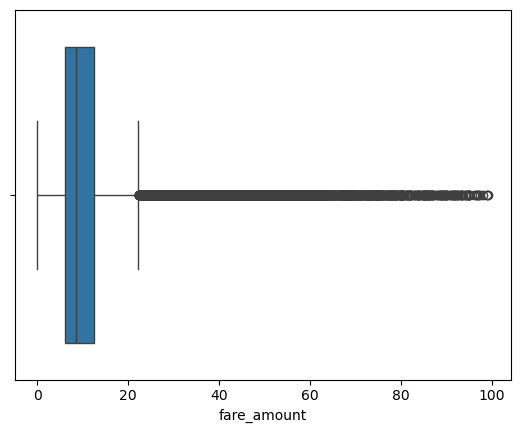

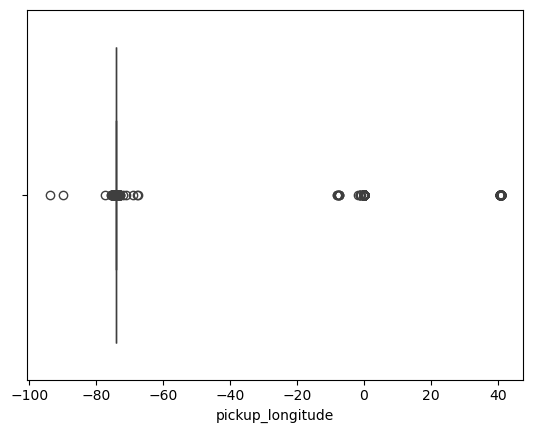

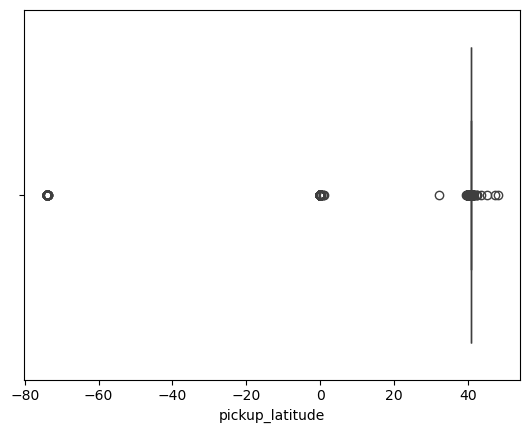

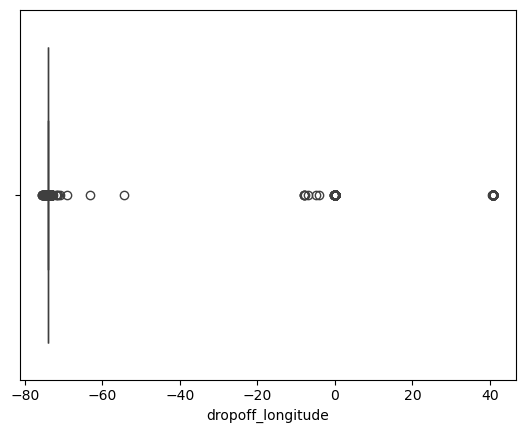

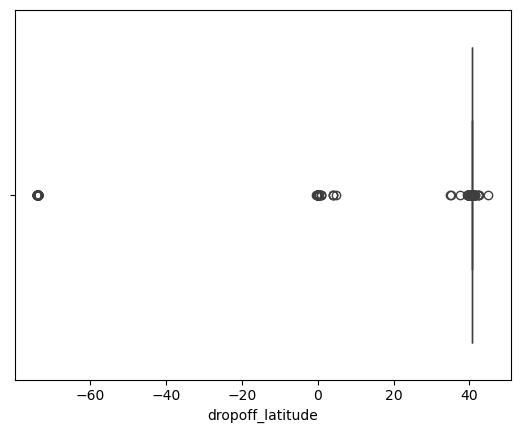

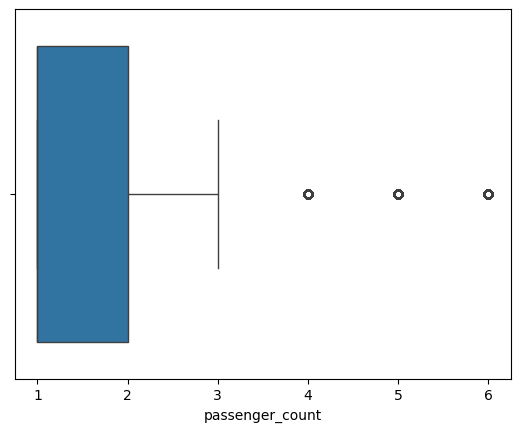

In [55]:
for col in df.select_dtypes(exclude=['object']):
     plt.figure()
     sns.boxplot(data=df,x=col)

In [56]:
def distance(lat1, lon1, lat2, lon2):
    lon1, lon2, lat1, lat2 = map(np.radians, [lon1, lon2, lat1, lat2])
    difflon = lon2 - lon1
    difflat = lat2 - lat1
    a = np.sin(difflat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(difflon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km


In [57]:
df['Distance'] = distance(df.pickup_latitude, df.pickup_longitude,
                          df.dropoff_latitude, df.dropoff_longitude)


In [58]:
df = df[df['Distance'] < 200]
df = df[df['Distance'] > 0]


In [59]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['weekday'] = df['pickup_datetime'].dt.day_name()
df['Year'] = df['pickup_datetime'].dt.year
df['Month'] = df['pickup_datetime'].dt.month
df['Hour'] = df['pickup_datetime'].dt.hour


In [60]:
def convert_weekday(day):
    if day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday']:
        return 0
    return 1

def convert_hour(hour):
    if 5 <= hour < 12: return 1
    elif 12 <= hour < 17: return 2
    elif 17 <= hour < 24: return 3
    else: return 0

df['weekday'] = df['weekday'].apply(convert_weekday)
df['Hour'] = df['Hour'].apply(convert_hour)


In [70]:
#df.head()
df.drop(columns=['pickup_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'], inplace=True)
X = df[['Distance']]
y = df['fare_amount']

In [71]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1))


In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, random_state=10)


In [73]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def fit_predict(model):
    model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    print("R^2:", r2_score(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE:", mean_absolute_error(y_test, y_pred))


In [74]:
from sklearn.linear_model import LinearRegression
fit_predict(LinearRegression())


R^2: 0.6600061266682061
RMSE: 0.578958120670813
MAE: 0.28717391238999107


In [77]:
from sklearn.ensemble import RandomForestRegressor
fit_predict(RandomForestRegressor())


R^2: 0.7067566565762297
RMSE: 0.5376822324018882
MAE: 0.3007676668714435


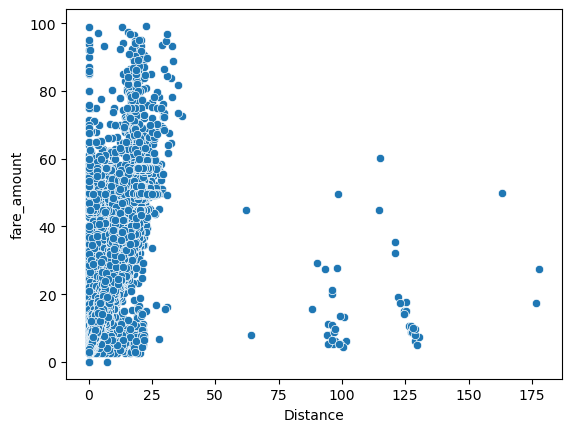

In [76]:
df.corr()
sns.scatterplot(y=df['fare_amount'], x=df['Distance'])
plt.show()
